### 多臂老虎机

#### 形式化描述

假设多臂老虎机有 $K$ 个拉杆，动作空间为 $A=\{a_1,\dots,a_K\}$，$a_t\in A$ 表示一个动作。

$R$ 为奖励概率分布。

目标是最大化一段时间步 $T$ 内累积的奖励 $\max \sum_{t=1}^{T}{r_t},\ r_t\sim R(\cdot|a_t)$，其中 $a_t$ 表示第 $t$ 时间的动作，$r_t$ 表示第 $t$ 时间的奖励。

#### 累积懊悔

对于一个动作 $a$，定义其期望奖励为 $Q(a)=\mathbb{E}_{r\sim R(\cdot|a)}[r]$，同时定义其中最优期望奖励为 $Q^*$。

引入动作的懊悔为 $R(a)=Q^*-Q(a)$，而累积懊悔就是一段时间步 $T$ 的懊悔总和 $\sigma_R=\sum_{t=1}^{T}{R(a_t)}$。

MAB问题的最大化累积奖励等价于最小化累积懊悔。

#### 估计期望奖励

通过多次拉动一根拉杆，计算得到多次奖励的期望，算法流程如下：
* 对于 $\forall a \in A$，初始化计数器 $N(a)=0$ 和期望奖励估计 $\hat{Q}(a)=0$。
* for $t=1 \to T$ do
* &nbsp;&nbsp;&nbsp;&nbsp; 选取某根拉杆，该动作记为 $a_t$
* &nbsp;&nbsp;&nbsp;&nbsp; 得到奖励 $r_t$
* &nbsp;&nbsp;&nbsp;&nbsp; 更新计数器 $N(a_t)=N(a_t)+1$
* &nbsp;&nbsp;&nbsp;&nbsp; 更新期望奖励估值：$\hat{Q}(a_t)=\hat{Q}(a_t)+\frac{1}{N(a_t)}[r_t-\hat{Q}(a_t)]$
* end for

增量式期望更新的公式推导如下：

$$
\begin{aligned}
Q_k&=\frac{1}{k}\sum_{i=1}^{k}{r_i} \\
&=\frac{1}{k}(r_k+\sum_{i=1}^{k-1}{r_i}) \\
&=\frac{1}{k}(r_k+(k-1)Q_{k-1}) \\
&=Q_{k-1}+\frac{1}{k}[r_k-Q_{k-1}]
\end{aligned}
$$

下面实现的一个拉杆数为 $K$ 的多臂老虎机，有 $p$ 的概率获得奖励 $1$。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 伯努利多臂老虎机
class BernoulliBandit:
    def __init__ (self, K):
        self.probs = np.random.uniform(size=K) # 随机生成 K 个拉杆的获奖概率
        self.best_index = np.argmax(self.probs) # 获奖概率最大的拉杆
        self.best_prob = self.probs[self.best_index]  # 最大的获奖概率
        self.K = K
    
    def step (self, k):
        if (np.random.rand() < self.probs[k]):
            return 1
        else:
            return 0

np.random.seed(1) # 设定随机种子
K = 10
bandit_10_arm = BernoulliBandit(K)

下面实现多臂老虎机算法的基本框架。

In [2]:
# 多臂老虎机基本框架
class Solver:
    def __init__ (self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K) # 每个拉杆的尝试次数，初始值为 0
        self.regret = 0 # 累积懊悔
        self.actions = [] # 记录每一步的动作
        self.regrets = [] # 记录每一步的累积懊悔
    
    def update_regret (self, k):
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)
    
    def run_one_step (self):
        # 由具体决策实现选择拉动的拉杆，目前尚未实现
        raise NotImplementedError
    
    def run (self, num_steps):
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

### 探索与利用的平衡

下面需要考虑设计一个策略，告诉我们每次需要采取哪个动作。在多臂老虎机中，一个经典的问题就是探索与利用的平衡问题。

**探索**指尝试更多的拉杆，**利用**是拉动期望奖励最大的拉杆。

我们需要平衡探索与利用的次数，使得累计奖励最大化，下面将学习一些经典的算法。

### $\epsilon$-贪心算法

$\epsilon$-贪心算法的公式如下：

$$
a_t=\left\{\begin{matrix}
\argmax_{a\in A}\hat{Q}(a)，采样概率：1-\epsilon\\从A中随机选择，采样概率：\epsilon
\end{matrix}\right.
$$

随着步数增加，每个动作的奖励估计会越准确，所以可以令 $\epsilon$ 随着时间减少，但不能减少为 $0$。

下面实现 $\epsilon$-贪心算法的代码。

In [3]:
# ϵ-贪心算法
class EpsilonGreedy (Solver):
    def __init__ (self, bandit, epsilon=0.01, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        self.estimates = np.array([init_prob] * self.bandit.K) # 初始化所有拉杆的期望奖励估计
    
    def run_one_step (self):
        if (np.random.rand() < self.epsilon):
            k = np.random.randint(0, self.bandit.K) # 随机选择拉杆
        else:
            k = np.argmax(self.estimates) # 选择期望奖励估计最大的拉杆
        r = self.bandit.step(k)
        self.estimates[k] += (r - self.estimates[k]) / (self.counts[k] + 1) # 更新期望奖励估计
        return k

利用绘图函数将累积懊悔的变化可视化。

In [4]:
def plot_results(solvers, solver_names):
    """输入 solvers 是一个列表，列表中的每个元素是一种特定的策略。而 solver_names 也是一个列表，存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel("Time steps")
    plt.ylabel("Cumulative regrets")
    plt.title("%d-armed bandit" % solvers[0].bandit.K)
    plt.legend()
    plt.show()

ϵ-贪心算法的累积懊悔为： 25.526630933945313


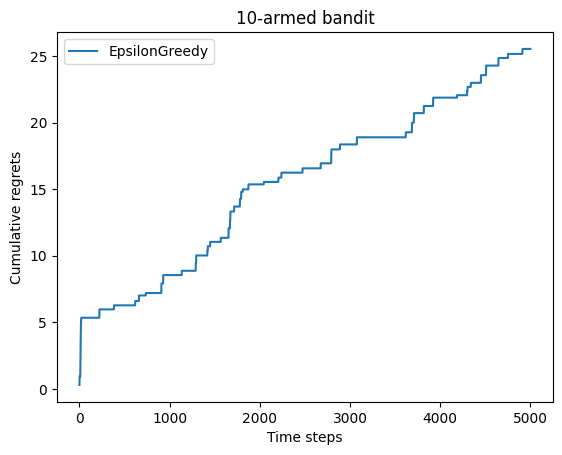

In [5]:
np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver.run(5000)
print("ϵ-贪心算法的累积懊悔为：", epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

接下来实现 $\epsilon$ 随时间衰减的 $\epsilon$-贪心算法，公式为 $\epsilon_t=\frac{1}{t}$。

随时间衰减的ϵ-贪心算法的累积懊悔为： 10.114334931260183


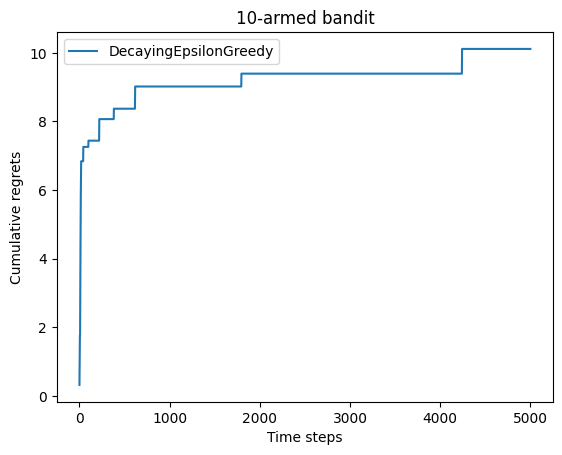

In [6]:
# 随时间衰减的 ϵ-贪心算法
class DecayingEpsilonGreedy (Solver):
    def __init__ (self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K) # 初始化所有拉杆的期望奖励估计
    
    def run_one_step (self):
        self.total_count += 1
        if (np.random.rand() < 1.0 / self.total_count):
            k = np.random.randint(0, self.bandit.K) # 随机选择拉杆
        else:
            k = np.argmax(self.estimates) # 选择期望奖励估计最大的拉杆
        r = self.bandit.step(k)
        self.estimates[k] += (r - self.estimates[k]) / (self.counts[k] + 1) # 更新期望奖励估计
        return k

np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print("随时间衰减的ϵ-贪心算法的累积懊悔为：", decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

### 上置信界算法

霍夫丁不等式：令 $X_1,\dots,X_n$ 为 $n$ 个独立同分布的随机变量，取值范围为 $[0,1]$，其经验期望为 $\bar{x}_n=\frac{1}{n}\sum_{j=1}^{n}{X_j}$，则有

$$
\mathbb{P}\{{\mathbb{E}}[X]\geq\bar{x}_n+u\}\leq e^{-2nu^2}
$$

那么将 $\hat{A}_t(a)$ 带入 $\bar{x}_t$，不等式中的参数 $u=\hat{U}_t(a)$ 代表不确定性度量。令 $p=e^{-2N_t(a)U_t(a)^2}$，那么根据上述不等式，$Q_t(a)<\hat{Q}_t(a)+\hat{U}_t(a)$ 至少以概率 $1-p$ 成立，当 $p$ 很小时，$\hat{Q}_t(a)+\hat{U}_t(a)$ 便是期望奖励上界。

所以上置信界算法便是选取期望奖励上界最大的动作，即 $a=\underset{a\in A}{\argmax}[\hat{Q}(a)+\hat{U}(a)]$，其中 $\hat{U}_t(a)=\sqrt{\frac{-\log p}{2N_t(a)}}$。

下面用代码实现上置信界算法，设置 $p=\frac{1}{t}$，并且令 $\hat{U}_t(a)=\sqrt{\frac{\log t}{2(N_t(a)+1)}}$，防止出现分母为 $0$ 的情况。同时可以设定一个系数 $c$ 来控制不确定性的比重，即 $a=\underset{a\in A}{\argmax}[\hat{Q}(a)+c\cdot \hat{U}(a)]$

上置信界算法的累积懊悔为： 70.45281214197854


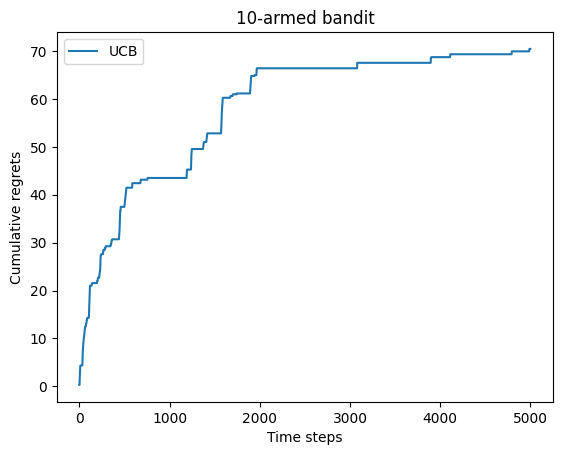

In [7]:
# 上置信界算法
class UCB (Solver):
    def __init__ (self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef
    
    def run_one_step (self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(np.log(self.total_count) / (2.0 * (self.counts + 1)))
        k = np.argmax(ucb)
        r = self.bandit.step(k)
        self.estimates[k] += 1.0 / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

np.random.seed(1)
UCB_solver = UCB(bandit_10_arm, coef=1.0)
UCB_solver.run(5000)
print("上置信界算法的累积懊悔为：", UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])

### 汤普森采样算法

假设每根拉杆的奖励服从一个特定的概率分布，然后每次选择期望奖励最大的拉杆。但是由于计算期望奖励的代价过大，所以先对每根拉杆进行一轮采样，再选择样本中奖励最大的拉杆。

采用 Beta 分布对所有拉杆的奖励概率分布进行建模，若某根拉杆在以往的拉动尝试中，有 $m_1$ 次奖励为 $1$，$m_2$ 次奖励为 $0$，则该拉杆的奖励服从参数为 $(m_1+1,m_2+1)$ 的 Beta 分布。

下面用代码实现汤普森采样算法。

汤普森采样算法的累积懊悔为： 57.19161964443925


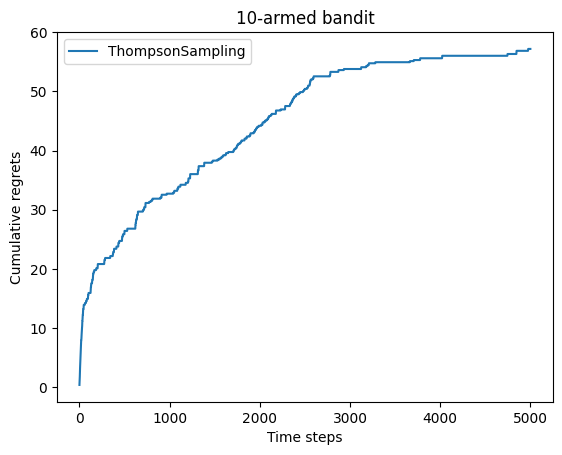

In [8]:
# 汤普森采样算法
class ThompsonSampling (Solver):
    def __init__ (self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.K) # 记录每根拉杆奖励为 1 的次数
        self._b = np.ones(self.bandit.K) # 记录每根拉杆奖励为 0 的次数
    
    def run_one_step (self):
        samples = np.random.beta(self._a, self._b) # 按照 Beta 分布采样一组奖励样本
        k = np.argmax(samples)
        r = self.bandit.step(k)
        self._a[k] += r
        self._b[k] += 1 - r # 更新 Beta 分布的参数
        return k

np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print("汤普森采样算法的累积懊悔为：", thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])